# Concept: Dual-Secret Oracle

### In this variant:

### 1. Oracle encodes two secret bit strings, s^(1) and s^(2)
 
### 2. Oracle returns 2 output bits: f(x)=(s^(1)⋅x mod 2,s^(2)⋅x mod 2)

### 3. Objective: Determine both secrets with one quantum query.

In [12]:
# Import Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import *
import matplotlib.pyplot as plt
import numpy as np


# Quantum circuit for dual-secret Bernstein-Vazirani problem.
# Encodes two secrets into two ancilla qubits.

def bernstein_vazirani_dual(s1: str,s2: str):
    n = len(s1)  # Number of qubits

    # Step 1: Initialize registers
    # We need n qubits for the input register and two ancillary qubit for the oracle.
    # We also need n classical bits to store the measurement results.
    # The qubits are automatically initialized to the state |0⟩.
    
    qc = QuantumCircuit(n + 2, n)

    # Step 2 To create the phase oracle, we need the ancillary qubit in the state |−⟩.
    # We achieve this by applying an X gate (to make it |1⟩) followed by a Hadamard gate.
    qc.x(n)
    qc.x(n+1)
    qc.h(n)
    qc.h(n+1)
    qc.barrier() # Add a barrier for visual clarity
    # Apply Hadamard gates to all input qubits
    # This puts the input register into a superposition of all possible states.
    qc.h(range(n))
    
    qc.barrier() # Add a barrier for visual clarity
    
   # Step 3: Apply the phase oracle U_f -  CNOTs based on s1 and s2
    # The oracle flips the phase of the states |x⟩ based on the secret string 's'.
    # It applies a CNOT for each '1' in the secret_string.
    # The i-th qubit is the control and the ancillary qubit is the target.
    # We iterate through the secret string in reverse because Qiskit orders qubits from right to left (q0, q1, ...).
    for i, bit in enumerate(reversed(s1)):
        if bit == '1':
            qc.cx(i, n) # Apply CNOT from data qubit i to the ancilla
            
    for i, bit in enumerate(reversed(s2)):
        if bit == '1':
            qc.cx(i, n+1) # Apply CNOT from data qubit i to the ancilla
            
    qc.barrier() # for visual separation

    # Step 4: Apply Hadamard gates again to the input qubits
    # This interferes the states to isolate the secret string 's'.
    qc.h(range(n))

    # Step 5: Measure the first n qubits
    # Measure the first n qubits
    qc.measure(range(n), range(n))

    return qc


# Quantum BV algorithm with phase oracle
def quantum_bv_circuit(s1: str,s2: str):
    qc = bernstein_vazirani_dual(s1,s2)
    # Simulate the circuit
    simulator = Aer.get_backend('aer_simulator')
    job = simulator.run(qc, shots=1024)
    result = job.result()
    #compiled_circuit = transpile(qc, simulator)
    #result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()  
    return [qc,counts]

# Example secrets
s1 = '1011'
s2 = '0110'

data = quantum_bv_circuit(s1,s2)
qc = data[0]
counts = data[1]
# Display result
print(f"First secret string (should be {s1}):")
print(f"Second secret string (should be {s2}):")
print("Measurement results (should show interference of both secrets):")
print(counts)

First secret string (should be 1011):
Second secret string (should be 0110):
Measurement results (should show interference of both secrets):
{'1101': 1024}


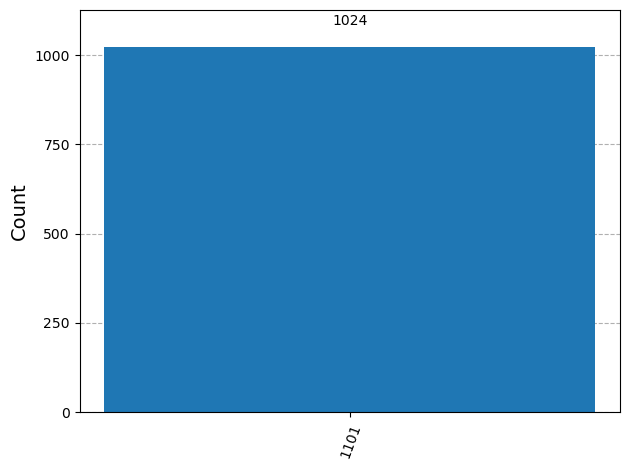

In [18]:
plot_histogram(counts)


In [20]:
plt.show()

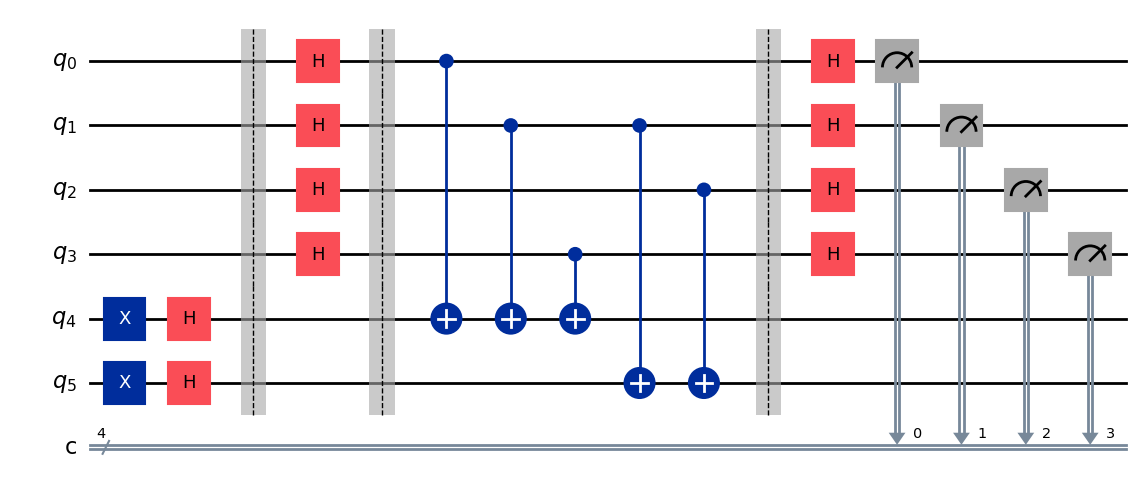

In [22]:
qc.draw('mpl')

# Results:
### 1. The measured output shows a single bitstring — not two!
### 2. Only interference pattern from both outputs is imprinted on the input register assumption(s1 XOR S2)
### 3. Only one combined result is observable: it is not possible to extract both secrets independently from a single run of the algorithm